In [2]:
!pip install snap
!pip install  nibabel

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch 1, Loss: 0.6483
Epoch 2, Loss: 0.6357
Epoch 3, Loss: 0.6302
Epoch 4, Loss: 0.6224
Epoch 5, Loss: 0.6251


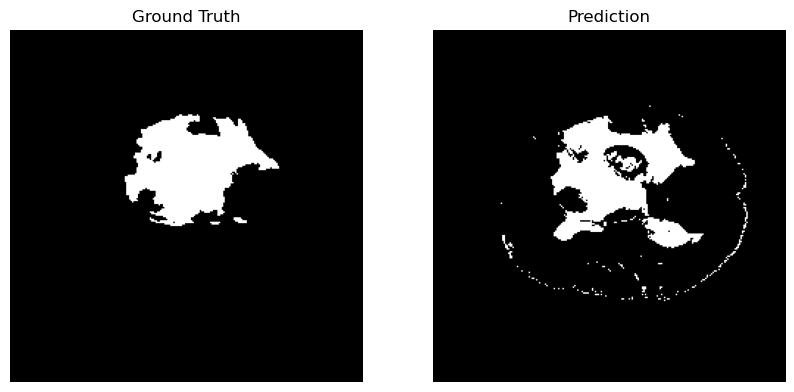

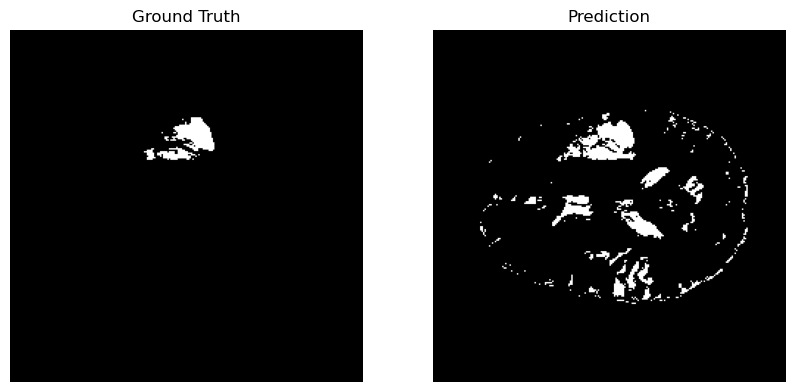

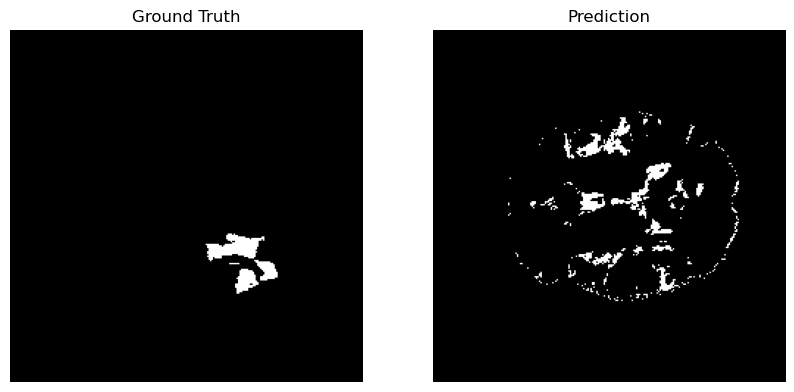

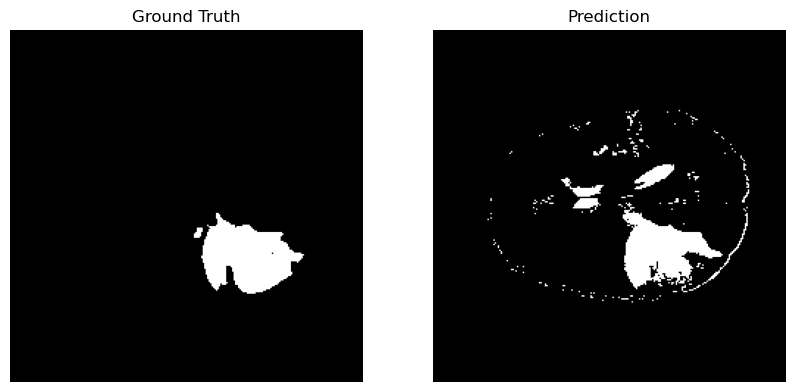

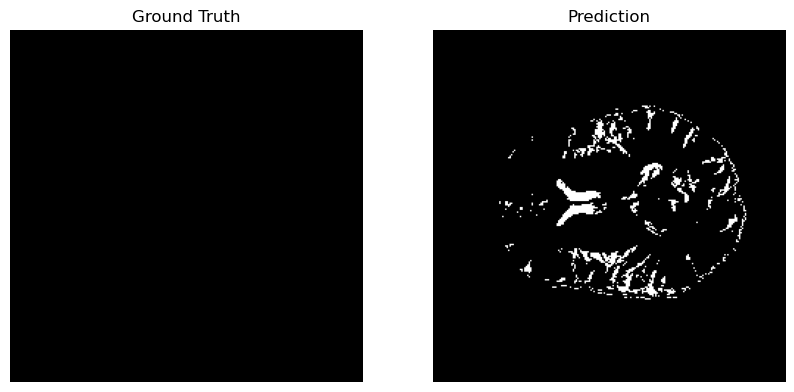

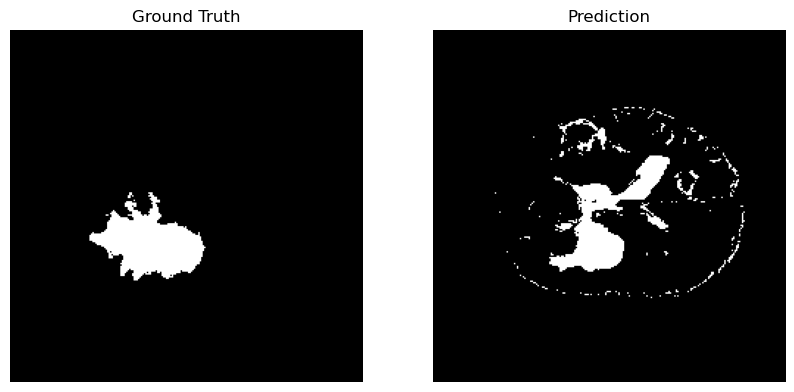

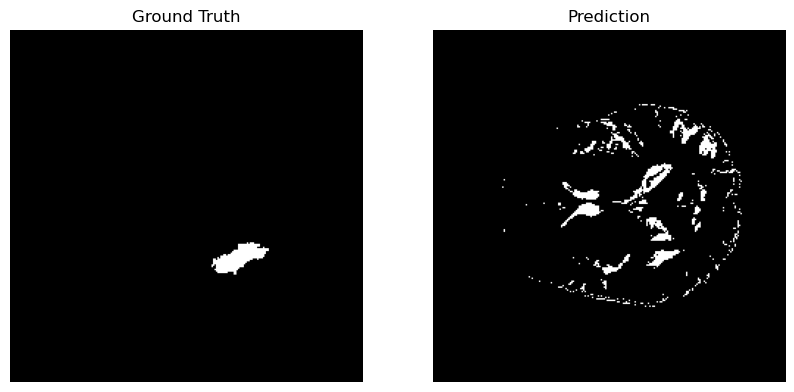

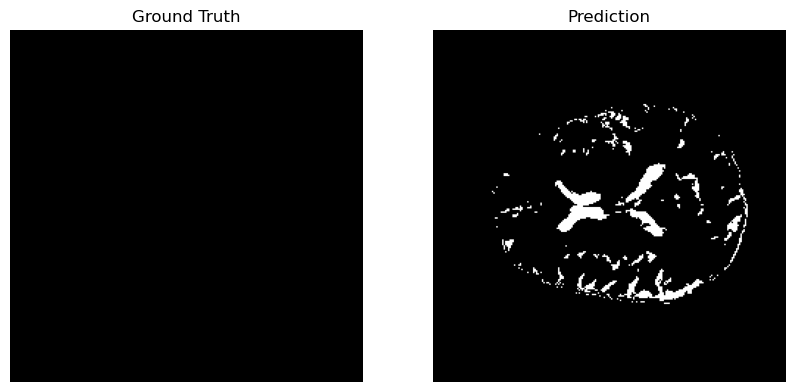

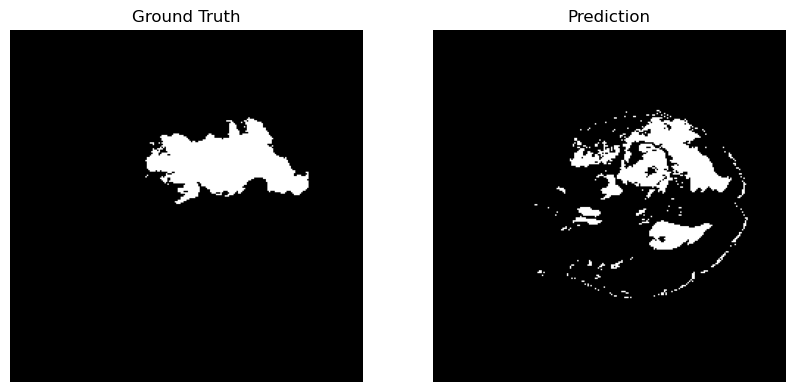

In [ ]:


def load_nifti(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

"""
class EOFormerModel(nn.Module):

    def __init__(self, num_classes=2):
        super(EOFormerModel, self).__init__()
        self.conv1 = nn.Conv3d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x
"""


class EOFormerModel(nn.Module):
    def __init__(self, num_classes=2):
        super(EOFormerModel, self).__init__()

        self.conv1 = nn.Conv3d(4, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, num_classes, kernel_size=1)
        self.dropout = nn.Dropout3d(p=0.3)  # Adding dropout with a 30% probability

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)  # Dropout after the first convolution
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)  # Dropout after the second convolution
        x = self.conv3(x)
        return x
    

def get_input_tensor(formatted_sample_num, sample_dir, sample_num):
    t1 = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_t1.nii"))
    t1ce = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_t1ce.nii"))
    t2 = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_t2.nii"))
    flair = load_nifti(os.path.join(sample_dir, f"{formatted_sample_num}_flair.nii"))

    input_np = np.stack([t1, t1ce, t2, flair], axis=0)
    input_np = (input_np - input_np.mean(axis=(1, 2, 3), keepdims=True)) / (
        input_np.std(axis=(1, 2, 3), keepdims=True) + 1e-8
    )
    input_tensor = torch.from_numpy(input_np).float().unsqueeze(0)  # [1, 4, D, H, W]
    return input_tensor


def get_ground_truth(sample_dir, sample_num):
    seg = load_nifti(os.path.join(sample_dir, f"{sample_num}_seg.nii"))
    seg = np.clip(seg, 0, 1)  # Binarize
    gt_tensor = torch.from_numpy(seg).long().unsqueeze(0).unsqueeze(0)  # [1, 1, D, H, W]
    return gt_tensor


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        probs = torch.softmax(logits, dim=1)
        targets_onehot = torch.nn.functional.one_hot(targets.squeeze(1), num_classes).permute(0, 4, 1, 2, 3).float()
        dims = (0, 2, 3, 4)
        intersection = torch.sum(probs * targets_onehot, dims)
        cardinality = torch.sum(probs + targets_onehot, dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        return 1 - dice_score.mean()


def visualize_prediction(gt_mask, pred_mask, slice_idx=77):
    gt_np = gt_mask.squeeze().detach().cpu().numpy()
    pred_np = pred_mask.squeeze().detach().cpu().numpy()

    if gt_np.ndim == 4:
        gt_np = gt_np[0]
    if pred_np.ndim == 4:
        pred_np = pred_np[0]

    gt_slice = gt_np[:, :, slice_idx]
    pred_slice = pred_np[:, :, slice_idx]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(gt_slice, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_slice, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    plt.show()


if __name__ == '__main__':
    model = EOFormerModel(num_classes=2)
    criterion = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_samples = [f"BraTS20_Training_{i:03d}" for i in range(1, 10)]
    sample_root_dir = "Downloads/BRATS/BRATS/MICCAI_BraTS2020_TrainingData"

    for epoch in range(5):
        model.train()
        total_loss = 0
        for sample_num in train_samples:
            sample_dir = os.path.join(sample_root_dir, sample_num)
            input_tensor = get_input_tensor(sample_num, sample_dir, sample_num)
            gt_mask = get_ground_truth(sample_dir, sample_num)

            output = model(input_tensor)
            loss = criterion(output, gt_mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_samples):.4f}")

    # After training: run inference and visualize predictions
    model.eval()
    inputs, preds, gts = [], [], []

    with torch.no_grad():
        for sample_num in train_samples:
            sample_dir = os.path.join(sample_root_dir, sample_num)
            input_tensor = get_input_tensor(sample_num, sample_dir, sample_num)
            gt_mask = get_ground_truth(sample_dir, sample_num)

            output = model(input_tensor)
            pred = torch.argmax(torch.softmax(output, dim=1), dim=1)

            inputs.append(input_tensor)
            preds.append(pred)
            gts.append(gt_mask)

    # Visualize
    for i in range(len(preds)):
        visualize_prediction(gts[i], preds[i])
